In [105]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

import warnings 
warnings.filterwarnings("ignore")

In [106]:
# AnnData object key
# odata - original anndata object containing all strains and circuit genes
# adata - contains genomically integrated strains and circuit genes
# bdata - contains genomically integrated strains without circuit genes
# obdata - contains all strains without circuit genes

In [200]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.signal import savgol_filter as sg
from scipy.io import loadmat
import seaborn as sn
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
from matplotlib.cm import ScalarMappable
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams.update({'font.size':23}); plt.rcParams.update({'axes.linewidth':2}); plt.rc('axes', axisbelow=True);
plt.rc('lines',linewidth=3); plt.rcParams['axes.spines.right'] = False; plt.rcParams['axes.spines.top'] = False 
plt.rcParams['xtick.major.size'] = 8; plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 2; plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.major.size'] = 8; plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['ytick.major.width'] = 2; plt.rcParams['ytick.minor.width'] = 1
plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True; 
# plt.rcParams['axes.autolimit_mode'] = 'round_numbers'
# plt.rcParams['axes.xmargin'] = 0
# plt.rcParams['axes.ymargin'] = 0
figDir = '/Users/aqib/Desktop/BCCL/char-syn-gene-nets/MSB_submission/figures/'

import seaborn as sns
import time
import scanpy as sc
import anndata as ad
from copy import deepcopy
from collections import Counter
import re
import json
from sklearn.metrics import r2_score, mean_squared_error, confusion_matrix
from sklearn.model_selection import train_test_split
from itertools import combinations
from random import choices

In [108]:
def concat_metadata2tpmdata(dftpm,dfmd):
    # add the metadata to the tpm data

    # find the rows of the metadata which correspond to the columns of the tpm data
    metalist = list(dfmd['sample_id'])
    dfmd_match_rowInd = []
    dftpm_match_colInd = []
    sid_count = 1
    for sid in dftpm.iloc[:,1:]:
        dfmd_match_rowInd.append(metalist.index(sid))
        dftpm_match_colInd.append(sid_count)
        sid_count = sid_count + 1
    # dfmd.iloc[dfmd_match_rowInd,:]

    # rename the row indices with the gene names
    dftpm_geneindex = dftpm.set_index('gene_id')
    dftpm_geneindex.index.names = [None]
    # dftpm_geneindex

    # create a dataframe, md2append, which contains just the metadata that correponds to the experiments in tpm data
    sids = list(dftpm_geneindex.columns)
    md2append = dfmd.T.iloc[:,dfmd_match_rowInd]
    md2append.columns = sids

    # concatenate the metadata to the top of the columns of tpm data
    dftpm_final = pd.concat([md2append,dftpm_geneindex[:]])
    # dftpm_final
    
    return(dftpm_final)

### Load data and metadata

In [109]:
df_tpm1 = pd.read_csv('ReadCountMatrix_preCAD_TPM_NANDiterate_1.tsv', sep='\t') # replicates 1,2,3,4 if they exist
df_tpm2 = pd.read_csv('ReadCountMatrix_preCAD_TPM_NANDiterate_2.tsv', sep='\t') # replicates 5,6,7,8 if they exist
df_metadata = pd.read_csv('NANDiterate_metadata.csv', sep=',')

In [110]:
df_tpm1_final = concat_metadata2tpmdata(df_tpm1,df_metadata)
df_tpm2_final = concat_metadata2tpmdata(df_tpm2,df_metadata)
df_tpm_final = pd.concat([df_tpm1_final,df_tpm2_final],axis=1)

### Remove samples with NaN values

In [111]:
sample_inds_with_nans = list(set(np.where(np.isnan(np.array(df_tpm_final.iloc[10:,:],dtype=np.float32)))[1]))
sample_with_nans = list(df_tpm_final.columns)[sample_inds_with_nans[0]]
df_tpm_final = df_tpm_final.drop(columns=[sample_with_nans],axis=1)

### Generate AnnData object 

In [112]:
obs_df = df_tpm_final.T.loc[:,['sample_id','timepoint','strain','temperature','replicate',
                               'arabinose_concentration','arabinose_unit','IPTG_concentration',
                               'IPTG_unit','strain_input_state']]
odata = sc.AnnData(np.array(df_tpm_final.T.iloc[:,10:],dtype=np.float32),obs=obs_df)
odata.var_names = list(df_tpm_final.index)[10:]

input_state = []
state = []
aras = np.sort(odata.obs.arabinose_concentration.unique())
iptgs = np.sort(odata.obs.IPTG_concentration.unique())
for ii, (ara,iptg) in enumerate(zip(odata.obs.arabinose_concentration,odata.obs.IPTG_concentration)):  

    if ara == aras[0]: 
        input_state.append( '(ara none,' )
        state.append('-/')
    elif ara == aras[1]:
        input_state.append( '(ara low,' )
        state.append('+/')
    elif ara == aras[2]:
        input_state.append( '(ara mid,'  ) 
        state.append('+/')
    elif ara == aras[3]:
        input_state.append( '(ara high,' )
        state.append('+/')
    
    if iptg == iptgs[0]: 
        input_state[ii] += ' IPTG none)'
        state[ii] += '-'
    elif iptg == iptgs[1]:
        input_state[ii] += ' IPTG low)'
        state[ii] += '+'
    elif iptg == iptgs[2]:
        input_state[ii] += ' IPTG mid)'   
        state[ii] += '+'
    elif iptg == iptgs[3]:
        input_state[ii] += ' IPTG high)'
        state[ii] += '+'
        
odata.obs['strain_input_state'] = input_state # fine-grained input state
odata.obs['input_state'] = state # coarse input state (just +/+)
odata.obs['timepoint'] = odata.obs['timepoint'].astype(str)
odata.obs['temperature'] = odata.obs['temperature'].astype(str)
# odata.obs['replicate'] = odata.obs['replicate'].astype(str)

sc.pp.log1p(odata)

In [113]:
odata = odata[:,~odata.var.index.isin(['rsd_1','rsd_2','fecA_1','fecA_2','rsd','fecA'])].copy()

In [114]:
# change names of some circuit genes
var_names = odata.var_names.tolist()
changelist = [['CamR','Actuator_YFP'],['CmR','YFP']]
for ii in range(len(changelist[0])):
    var_names[var_names.index(changelist[0][ii])] = changelist[1][ii]
odata.var_names = var_names

In [115]:
circuit_genes = odata.var_names[-9:]

### Remove plasmid strains from object

In [116]:
adata = odata[~odata.obs.strain.isin(['MG1655_pJS007_LALT__backbone','MG1655_pJS007_LALT__P3__PhlF',
                                     'MG1655_pJS007_LALT__I1__IcaRA'])].copy()

odata = odata[~odata.obs.strain.isin(['MG1655_pJS007_LALT__backbone'])].copy()

In [117]:
# rename and reorder strains
odata.obs['strain1'] = odata.obs['strain'].map({'MG1655_WT':'wild-type',
                                                'MG1655_empty_landing_pads':'landing_pads',
                                                'MG1655_pBADmin':'pBADmin',
                                                'MG1655_pTACmin':'pTACmin',
                                                'MG1655_PhlF_Gate':'PhlF_Gate',
                                                'MG1655_IcaR_Gate':'IcaR_Gate',
                                                'MG1655_NAND_Circuit':'NAND_Circuit',
                                                'MG1655_pJS007_LALT__P3__PhlF':'pJ2007_PhlF',
                                                'MG1655_pJS007_LALT__I1__IcaRA':'pJ2007_IcaR'})
odata.obs.strain = odata.obs.strain1
odata.obs['strain'] = pd.Categorical(odata.obs.strain)

adata.obs['strain1'] = adata.obs['strain'].map({'MG1655_WT':'wild-type',
                                                'MG1655_empty_landing_pads':'landing_pads',
                                                'MG1655_pBADmin':'pBADmin',
                                                'MG1655_pTACmin':'pTACmin',
                                                'MG1655_PhlF_Gate':'PhlF_Gate',
                                                'MG1655_IcaR_Gate':'IcaR_Gate',
                                                'MG1655_NAND_Circuit':'NAND_Circuit'})
adata.obs.strain = adata.obs.strain1
adata.obs['strain'] = pd.Categorical(adata.obs.strain)

In [118]:
strain_order_list_all = ['wild-type','landing_pads','pBADmin','pTACmin','PhlF_Gate','IcaR_Gate','NAND_Circuit',
                        'pJ2007_PhlF','pJ2007_IcaR']
odata.obs['strain'].cat.reorder_categories(strain_order_list_all, inplace=True)

strain_order_list = ['wild-type','landing_pads','pBADmin','pTACmin','PhlF_Gate','IcaR_Gate','NAND_Circuit']
adata.obs['strain'].cat.reorder_categories(strain_order_list, inplace=True)

In [119]:
# add obs column for 'wild-type', 'landing_pads', and 'circuit' for all other strains
type_list = []
for strain in adata.obs.strain:
    if strain == 'wild-type':
        type_list.append( 'wild-type' )
    elif strain == 'landing_pads':
        type_list.append( 'landing_pads' )
    else: 
        type_list.append( 'circuit' )
adata.obs['type'] = type_list

### Create a new AnnData object without circuit genes

In [120]:
bdata = adata[:,0:-9].copy() # genomically integrated strains
obdata = odata[:,0:-9].copy() # all strains

# import pickle
# pickle.dump(odata,open('odata_NANDiterate.pkl','wb'))

strain colors

In [121]:
strain_palette = [[100/255,190/255,180/255],'tab:blue','tab:red','tab:purple','tab:orange','tab:green','dimgray']

add a column for the class: wild-type or synthetic

In [122]:
obdata.obs.strain1 = ['wild-type' if obdata.obs.strain1.isin(['wild-type'])[ii] 
             else 'synthetic' for ii in range(obdata.n_obs)]


In [123]:
obdata.obs.rename(columns={'strain1': 'label'}, inplace=True)

In [137]:
y = obdata.obs.label.values

In [141]:
# y = np.array([0 if x == 'wild-type' else 1 for x in y],dtype='float32')
y[y == 'wild-type'] = 0.
y[y == 'synthetic'] = 1.
y = np.array(y,dtype='float32')

In [139]:
X = obdata.X

stratify the dataset by class

In [312]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=1, shuffle=True, stratify=obdata.obs.timepoint)
len(X_train), len(X_test)


(201, 806)

Train classifier

In [313]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [314]:
# clf = RandomForestClassifier(max_depth=5, random_state=0, criterion='entropy')
clf = SVC(kernel="linear", C=0.025)

In [315]:
clf.fit(X_train, y_train)

SVC(C=0.025, kernel='linear')

In [316]:
clf.score(X_test, y_test)

0.9987593052109182

In [317]:
cm = confusion_matrix(y_test, clf.predict(X_test))

<AxesSubplot:>

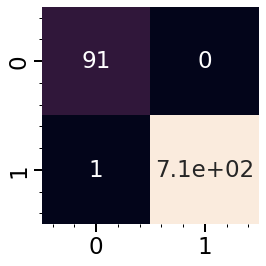

In [318]:
sns.heatmap(cm,annot=True,cbar=False,square=True)

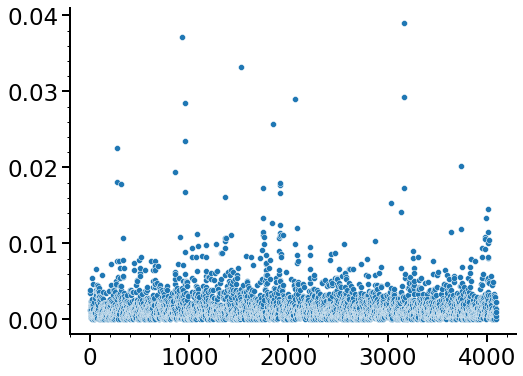

In [319]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=range(X_test.shape[1]), y=np.abs(np.squeeze(clf.coef_)))
# plt.yscale('log')
plt.show()

In [320]:
obdata.var_names[np.argsort(np.squeeze(np.abs(clf.coef_)))][-1]

'ompR'

In [321]:
def plot_ts(adata, this_gene,this_ylim=0.0):
    fig, ax = plt.subplots(2,4,figsize=(16,8),sharex=True,sharey=True)
#     fig.delaxes(ax[-1,-1])
    ax = ax.reshape(-1)
    plt.suptitle(this_gene)
    for ii, strain in enumerate(strain_order_list):
        gene_ts = []
        for time in adata.obs.timepoint.unique():
            sub_obs = (adata.obs.timepoint.isin([time])) & (adata.obs.strain.isin([strain]))
            yplot = (adata[sub_obs,this_gene].X.reshape(-1).toarray()).tolist()
            gene_ts.append(yplot)
        gene_df = pd.DataFrame({'5.0': pd.Series(gene_ts[0]), '6.5': pd.Series(gene_ts[1]), '8.0': pd.Series(gene_ts[2]), '18.0': pd.Series(gene_ts[3])})
        ax[ii].set_title(strain)
        sns.lineplot(data=gene_df.median(axis=0),ax=ax[ii],color='k')
        sns.stripplot(data=gene_df,ax=ax[ii],palette=['r','g','b','c'])
        sns.lineplot(data=gene_df.median(axis=0),ax=ax[-1],color=strain_palette[ii])
    ax[0].set_ylim(this_ylim,)
    plt.show()

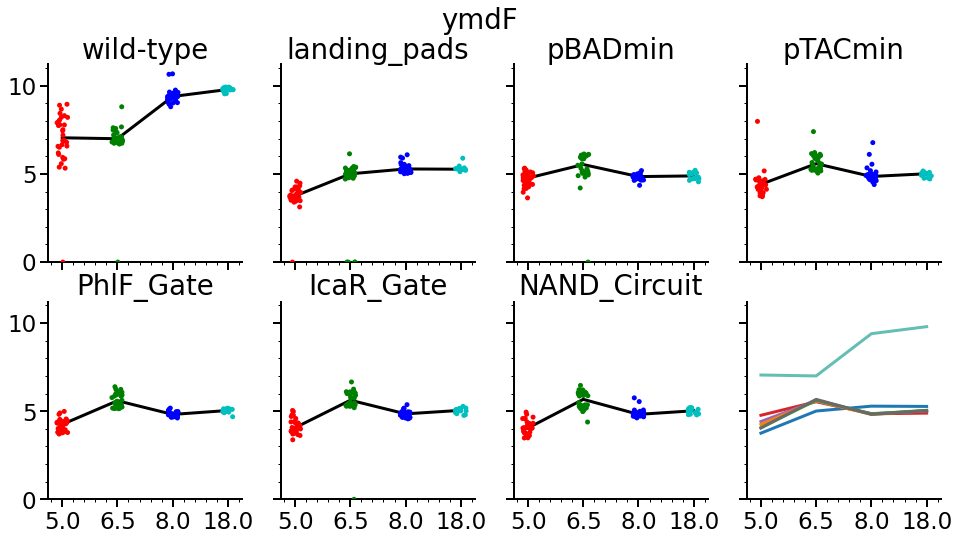

In [324]:
plot_ts(adata, obdata.var_names[np.argsort(np.squeeze(np.abs(clf.coef_)))][-2], this_ylim=0)

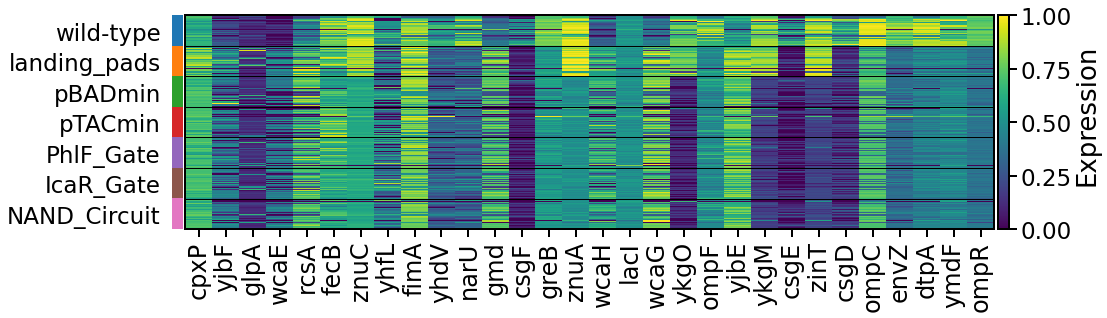

In [325]:


plt.rcParams['xtick.minor.visible'] = False; plt.rcParams['ytick.minor.visible'] = False; 
plt.rcParams['axes.spines.right'] = True; plt.rcParams['axes.spines.top'] = True; 

this_ax = sc.pl.heatmap(adata, 
              var_names=adata.var_names[np.argsort(np.squeeze(np.abs(clf.coef_)))][-30:].tolist(), 
              groupby='strain',
              swap_axes=False,figsize=(15,4),
              cmap='viridis',standard_scale='var',
              show=False) # ,save='_circuit_state_biomarkers_down.pdf'
this_ax['groupby_ax'].set_ylabel('')
this_ax['groupby_ax'].set_yticklabels(strain_order_list,fontsize=23)

fig = plt.gcf()
cbar_ax = fig.axes[-1]
plt.text(82,600,'Expression',fontsize=26,rotation=90)
fig.axes[0].set_xticklabels(adata.var_names[np.argsort(np.squeeze(np.abs(clf.coef_)))][-30:].tolist(),fontsize=24)


plt.show()

plt.rcParams['xtick.minor.visible'] = True; plt.rcParams['ytick.minor.visible'] = True; 
plt.rcParams['axes.spines.right'] = False; plt.rcParams['axes.spines.top'] = False; 